Una tienda ha recopilado datos históricos de ventas mensuales durante varios años, en el
archivo Sales_Data.xlsx. Tu tarea es desarrollar un modelo que sea capaz de predecir las
ventas mensuales futuras basándose en estos datos.


In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.7 MB/s eta 0:00:00


In [4]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Cargamos el conjunto de datos sales_data.xlsx y la revisamos
df = pd.read_excel("Sales_Data.xlsx")
print(df.shape)
df.head()

(48, 2)


,Order Date,Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [ ]:
# Seteamos la columna date como indice
df = df.set_index('Order Date')
print(df.shape)
df.head()

(48, 1)


,Sales
Order Date,
2015-01-01,14205.707
2015-02-01,4519.892
2015-03-01,55205.797
2015-04-01,27906.855
2015-05-01,23644.303


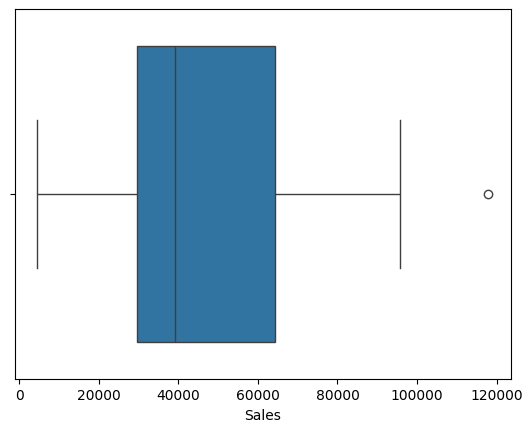

In [7]:

sns.boxplot(data=df, x='Sales')
plt.show()


In [8]:
# Eliminamos upliers con metodo de quantiles
Q1 = df["Sales"].quantile(0.25)
Q3 = df["Sales"].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df["Sales"] < (Q1-1.5*IQR)) | (df["Sales"] > (Q3 + 1.5 * IQR)))]
df

,Order Date,Sales
0,2015-01-01,14205.7070
1,2015-02-01,4519.8920
2,2015-03-01,55205.7970
3,2015-04-01,27906.8550
4,2015-05-01,23644.3030
5,2015-06-01,34322.9356
6,2015-07-01,33781.5430
7,2015-08-01,27117.5365
8,2015-09-01,81623.5268
9,2015-10-01,31453.3930


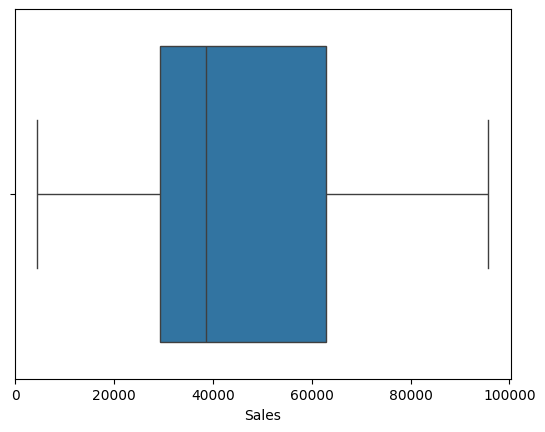

In [9]:
sns.boxplot(data=df, x='Sales')
plt.show()

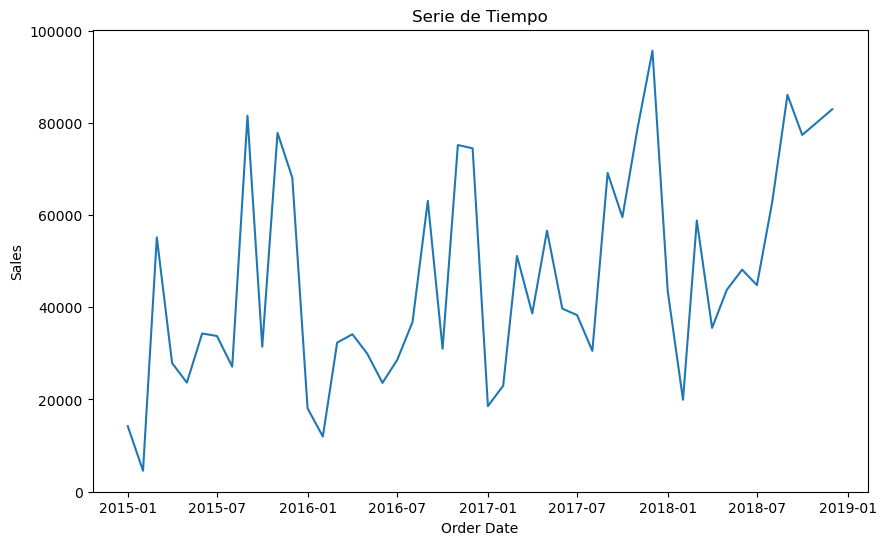

In [ ]:
# Analizamos el gráfico de la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df)
plt.title("Serie de Tiempo")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
# Descomponer la serie de tiempo en 3 componentes “trend”, “seasonal” y “resid”.
result = seasonal_decompose(df, model='additive', period=12)

Graficamos cada una de las componentes por separado

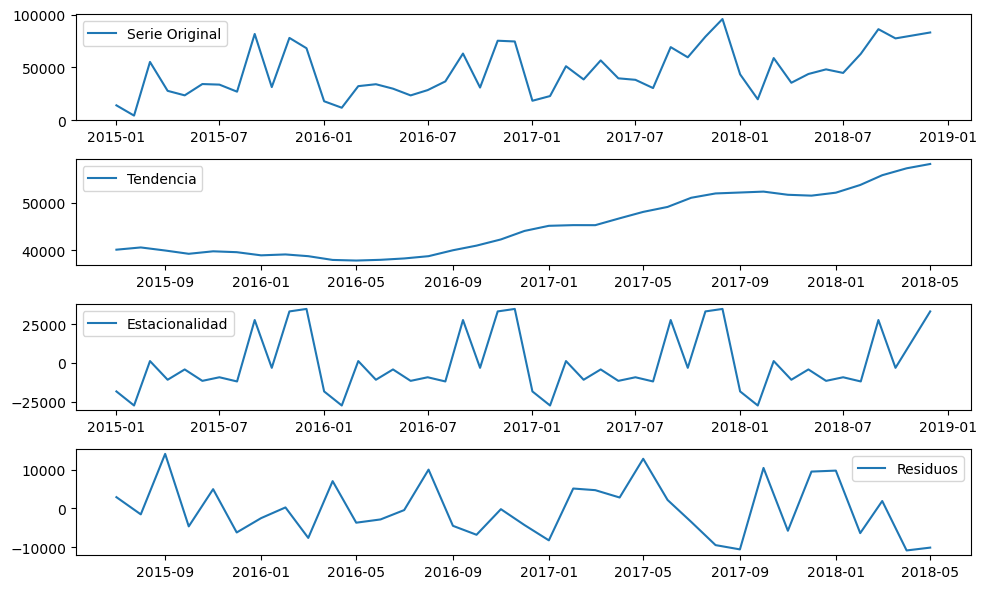

In [ ]:
# Graficar los componentes
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(df, label='Serie Original')
plt.legend()
plt.subplot(4, 1, 2)

plt.plot(result.trend, label='Tendencia')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuos')
plt.legend()
plt.tight_layout()
plt.show()

Se observa claramente una tendencia creciente en el tiempo y una estacionalidad clara.
Ahora procedemos a Dickey-Fuller, para ver el valor de “d”.

Dickey Fuller

In [ ]:
d = 0
p_value = adfuller(df['Sales'])[1]
diff_data = df['Sales']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1


print(f'P Value: {p_value}\t Number of differencing needed: {d}')

P Value: 7.69082086368302e-05	 Number of differencing needed: 0


En este caso el valor p es menor que 0,05 (0,0002779), se rechaza la hipótesis nula y se considera que la serie es estacionaria, no es necesario aplicar diferenciacion

Análisis de autocorrelación

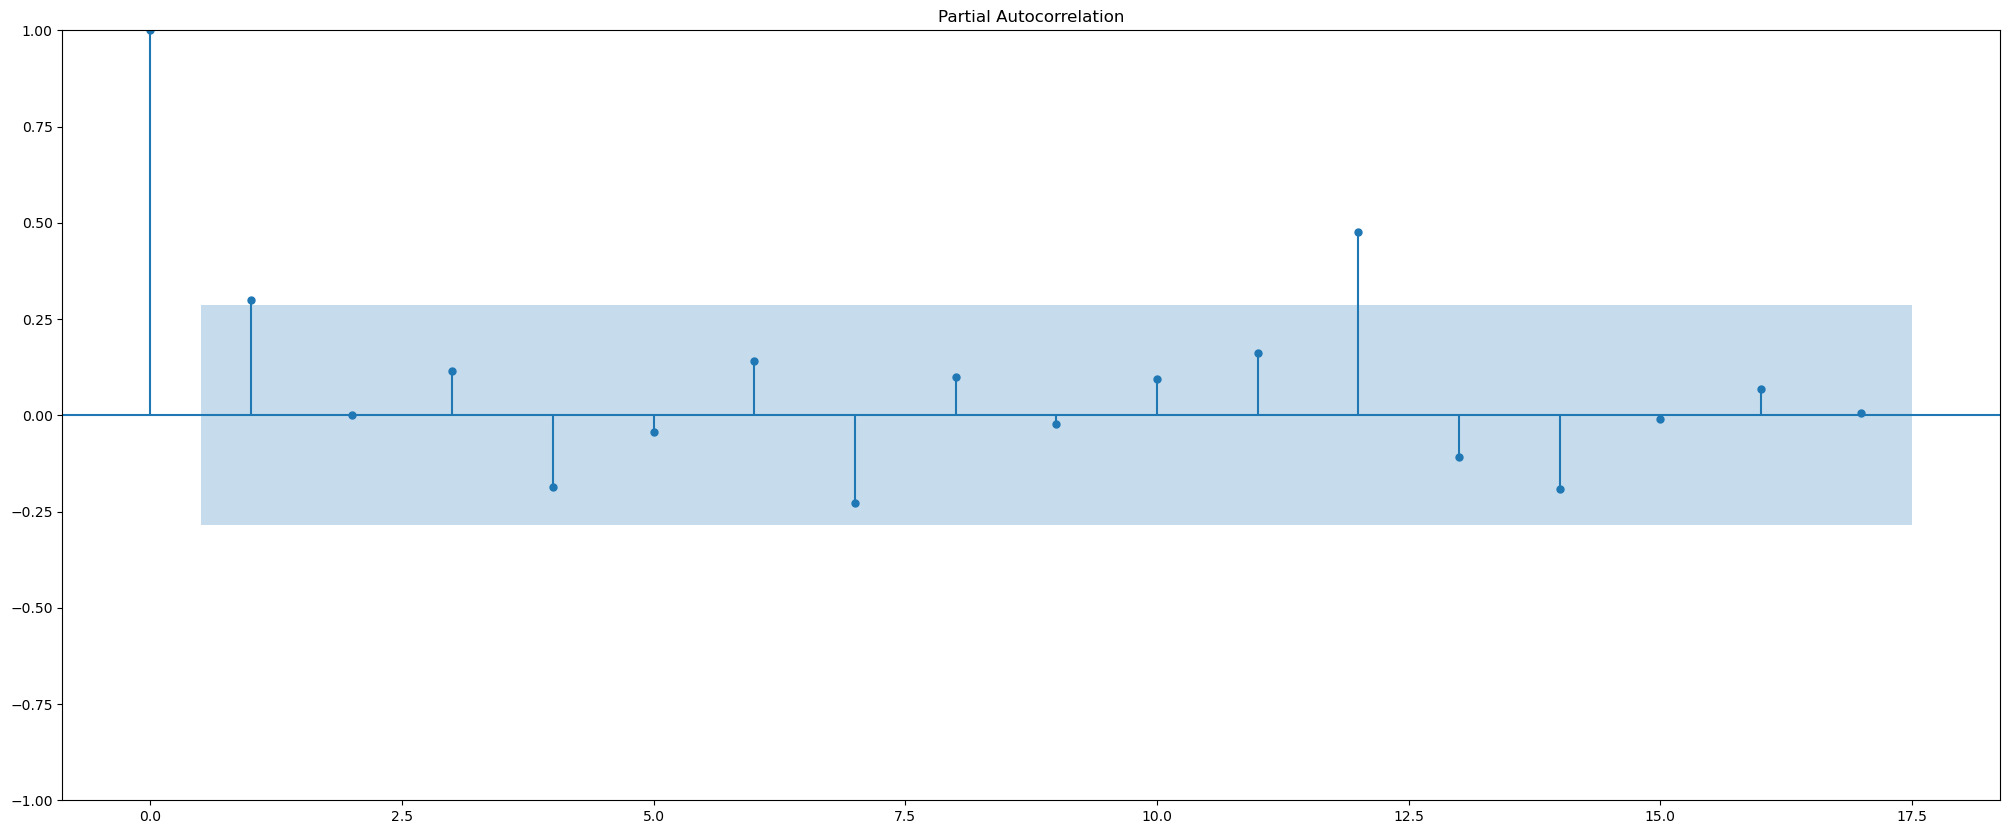

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(diff_data.dropna(),  alpha=0.05,ax=ax)
plt.show()

El último valor significativo es 12.5.

Ahora utilizamos la función de correlación para obtener el último valor.

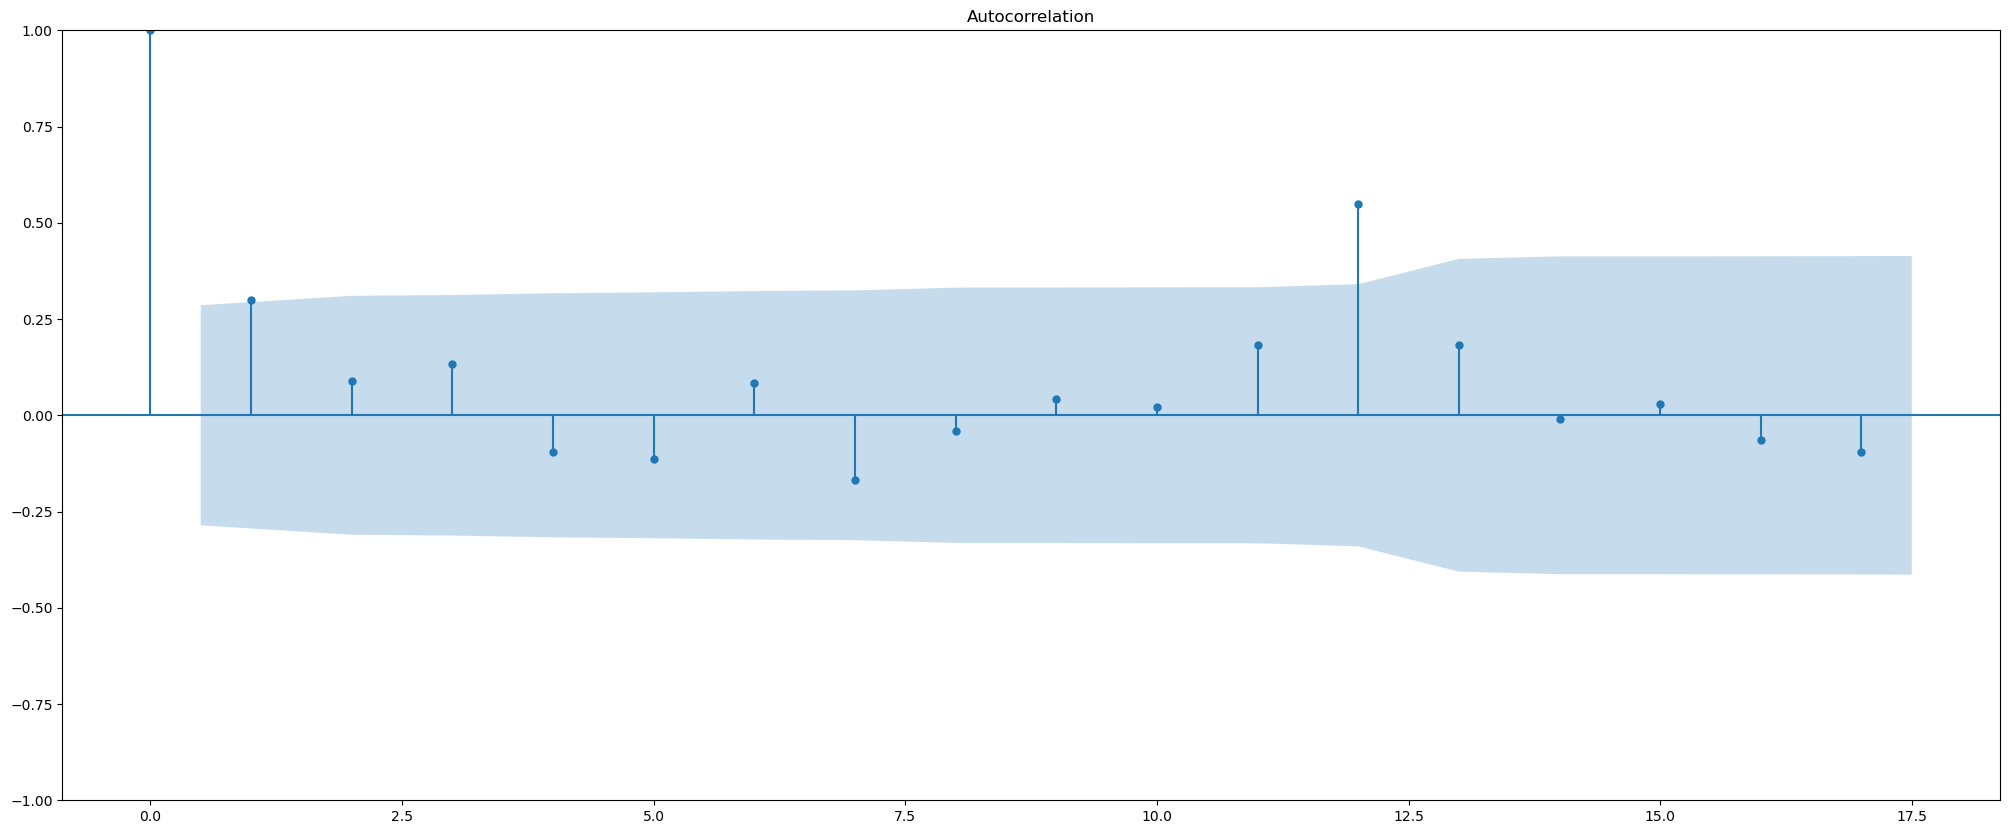

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(diff_data.dropna(), alpha=0.05, ax=ax)
plt.show()

Se tomanran 12 picos significativos

In [ ]:
# Separamos los datos en entrenamiento y prueba
train_size = int(len(df) * 0.8)

train_data, test_data = df[:train_size], df[train_size:]

In [ ]:
train_data.shape , test_data.shape

((37, 1), (10, 1))

In [ ]:
#Modelo ARIMA:Se toman los datos de p, d y q de acuerdo a los datos y los resultados de los análisis de autocorrelación y estacionariedad de las gráficas
#p = 12, d = 0, q= 1

p = int(input("Ingrese el valor de p: "))
q = int(input("Ingrese el valor de q: "))

model_arima = ARIMA(train_data['Sales'], order=(p, 0, q))
model_arima_fit = model_arima.fit()

Ingrese el valor de p:  12
Ingrese el valor de q:  1


In [ ]:
# auto_arima
model_auto_arima = auto_arima(train_data['Sales'], seasonal=True, m=12)

In [ ]:
# Modelo MA
model_ma = ARIMA(train_data["Sales"], order=(0, 0, q))
model_ma_fit = model_ma.fit()

In [ ]:
# Realizar predicciones test
forecast_arima = model_arima_fit.forecast(steps=len(test_data))
forecast_ma = model_ma_fit.forecast(steps=len(test_data))
forecast_auto_arima = model_auto_arima.predict(n_periods=len(test_data))

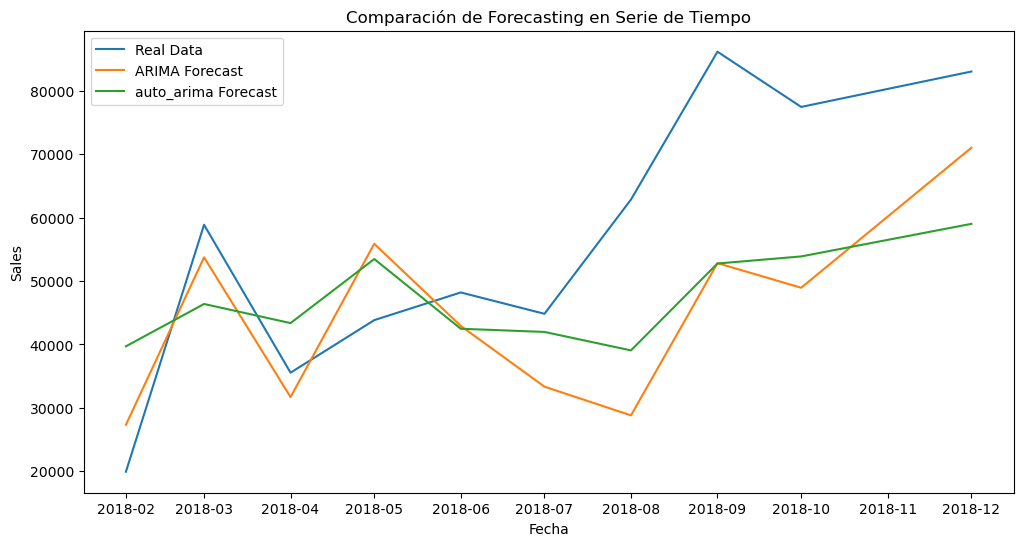

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))

plt.plot(test_data.index, test_data['Sales'], label='Real Data')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast')
plt.plot(test_data.index, forecast_auto_arima, label='auto_arima Forecast')
plt.xlabel('Fecha')
plt.ylabel('Sales')
plt.title('Comparación de Forecasting en Serie de Tiempo')
plt.legend()
plt.show()

In [ ]:
# Evaluamos el rendimiento de los modelos
def evaluate_model(predictions, test):
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(test, predictions)

    return rmse, r_squared

rmse_arima, r2_arima = evaluate_model(forecast_arima, test_data["Sales"])
rmse_auto_arima, r2_auto_arima = evaluate_model(forecast_auto_arima, test_data["Sales"])
rmse_ma, r2_ma = evaluate_model(forecast_ma, test_data["Sales"])

print(f"RMSE ARIMA: {rmse_arima:.2f}, R^2 ARIMA: {r2_arima:.2f}")
print(f"RMSE AUTO ARIMA: {rmse_auto_arima:.2f}, R^2 AUTO ARIMA: {r2_auto_arima:.2f}")
print(f"RMSE MA: {rmse_ma:.2f}, R^2 MA: {r2_ma:.2f}")

RMSE ARIMA: 19047.43, R^2 ARIMA: 0.14
RMSE AUTO ARIMA: 18857.74, R^2 AUTO ARIMA: 0.16
RMSE MA: 24225.48, R^2 MA: -0.39


In [ ]:
# Hacer predicciones con el modelo ARIMA
inicio_ar = len(train_data)
final_ar = len(train_data) + len(test_data) - 1
prediccion_ar = model_arima_fit.predict(inicio = inicio_ar, final = final_ar, dynamic=False)

# Hacer predicciones con el modelo MA
inicio_ma = len(train_data)
final_ma = len(train_data) + len(test_data) - 1
prediccion_ma = model_ma_fit.predict(inicio = inicio_ma, final= final_ma, dynamic=False)

print(f"Para ARIMA los valores de p y q son: {p}, {q}")
print(f"Para MA el valor de q es: {q}")

Para ARIMA los valores de p y q son: 12, 1
Para MA el valor de q es: 1


Analizando resultados

RMSE (Root Mean Squared Error):

El RMSE es una medida de la diferencia entre los valores reales y los valores predichos. Cuanto menor sea el RMSE, mejor será el ajuste del modelo a los datos.
El modelo AUTO ARIMA tiene el RMSE más bajo, lo que sugiere un mejor ajuste a los datos en comparación con los otros dos modelos.

R^2 (Coeficiente de Determinación):

El R^2 mide la proporción de la variabilidad en la variable dependiente que es explicada por el modelo. Valores más cercanos a 1 indican un buen ajuste, mientras que valores cercanos a 0 indican que el modelo no explica bien la variabilidad.
En este caso, los valores son:
ARIMA: 0.14
AUTO ARIMA: 0.16
MA: -0.39
El modelo AUTO ARIMA tiene el R^2 más alto, lo que sugiere que explica una mayor proporción de la variabilidad en los datos en comparación con los otros dos modelos.

Ambos valores de RMSE y R^2 indican que los modelos tienen un rendimiento modesto. El modelo AUTO ARIMA parece ser ligeramente mejor en términos de ajuste a los datos en comparación con ARIMA y MA.

Posibles Mejoras:

Realizar el estudio aumentando la cantidad de datos, puede mejorar significativamente el modelo